In [1]:
import argparse
import logging
import os
import sys

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

sys.path.append("../superlayer/utils/")
import utils as help
sys.path.append("../scripts/")
from eval import eval_net
sys.path.append("../superlayer/")
from models import UNet
from models import TiedUNet

from torch.utils.tensorboard import SummaryWriter
from dataset import BrainD
from torch.utils.data import DataLoader, random_split

from dice_loss import dice_coeff
from dice_loss import one_hot

from train import train_net 
from train import get_args

from matplotlib import pyplot as plt

In [2]:
dir_img = '/home/gid-dalcaav/projects/neuron/data/t1_mix/proc/resize256-crop_x32-slice100/train/vols/'
dir_mask = '/home/gid-dalcaav/projects/neuron/data/t1_mix/proc/resize256-crop_x32-slice100/train/asegs/'
dir_checkpoint_1 = 'checkpoints_1/'
dir_checkpoint_2 = 'checkpoints_2/'

np.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(threshold=10_000)

In [3]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
args = get_args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

INFO: Using device cuda


In [4]:
target_label_numbers = [0,2,3,4,10,16,17,28,31,41,42,43,49,53,63]
val_percent = 0.1
batch_size = args.batchsize
lr = args.lr
img_scale = args.scale

dataset = BrainD(dir_img, dir_mask, label_numbers=target_label_numbers)
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - 2 * n_val
n_test = n_val
train, val, test = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train, batch_size=8, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val, batch_size=8, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')

INFO: Creating dataset with 7329 examples


In [5]:
one_example = next(iter(train_loader))

image = one_example['image'][0]
mask = one_example['mask'][0]

print(image.shape)
print(mask.shape)

sq_img = image.squeeze(0).squeeze(0)
sq_msk = mask.squeeze(0).squeeze(0)

torch.Size([1, 160, 192])
torch.Size([1, 160, 192])


torch.Size([160, 192])


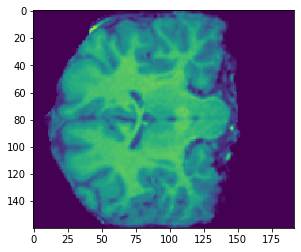

In [6]:
print(sq_img.shape)
plt.imshow(sq_img)

torch.Size([160, 192])


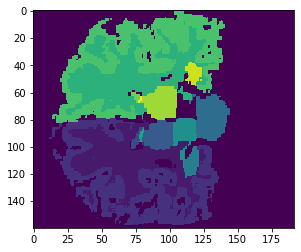

In [7]:
print(sq_msk.shape)
plt.imshow(sq_msk)

In [8]:
net1 = UNet(n_channels=1, n_classes=15, bilinear=True)

logging.info(f'Network:\n'
             f'\t{net1.n_channels} input channels\n'
             f'\t{net1.n_classes} output channels (classes)\n'
             f'\t{"Bilinear" if net1.bilinear else "Transposed conv"} upscaling')

net1.to(device=device)
train_scores1, val_scores1, train_var_1, val_var_1 = train_net(net=net1,
                                                                epochs=args.epochs,
                                                                batch_size=args.batchsize,
                                                                lr=args.lr,
                                                                device=device,
                                                                img_scale=args.scale,
                                                                val_percent=args.val / 100,
                                                                checkpoint=1,
                                                                target_label_numbers=target_label_numbers,
                                                                dataset=dataset,
                                                                train_loader=train_loader,
                                                                val_loader=val_loader,
                                                                writer=writer)

INFO: Network:
	1 input channels
	15 output channels (classes)
	Bilinear upscaling
INFO: Starting training:
        Epochs:          3
        Batch size:      8
        Learning rate:   0.001
        Training size:   6597
        Validation size: 732
        Checkpoints:     True
        Device:          cuda
        Images scaling:  1
    
Validation round:  98%|█████████▊| 89/91 [00:06<00:00, 20.53batch/s]
                                                                    INFO: Validation Dice Loss: 0.07382842259747642
Validation round: 100%|██████████| 91/91 [00:04<00:00, 24.25batch/s]
                                                                    INFO: Validation Dice Loss: 0.054641747212671975
Validation round:  99%|█████████▉| 90/91 [00:04<00:00, 24.56batch/s]
                                                                    INFO: Validation Dice Loss: 0.06009106133337859
Validation round:   8%|▊         | 7/91 [00:00<00:27,  3.06batch/s]


Validation round:  99%|█████████▉| 90/91 [00:04<00:00, 23.19batch/s]
                                                                    INFO: Validation Dice Loss: 0.05470990062087447
Validation round: 100%|██████████| 91/91 [00:04<00:00, 26.93batch/s]
                                                                    INFO: Validation Dice Loss: 0.05086265799108442
Validation round:  99%|█████████▉| 90/91 [00:04<00:00, 26.59batch/s]
                                                                    INFO: Validation Dice Loss: 0.050084107115373505
Validation round:  37%|███▋      | 34/91 [00:01<00:03, 18.61batch/s]


Validation round: 100%|██████████| 91/91 [00:04<00:00, 23.30batch/s]
                                                                    INFO: Validation Dice Loss: 0.04936763365845104
Validation round: 100%|██████████| 91/91 [00:04<00:00, 27.58batch/s]
                                                                    INFO: Validation Dice Loss: 0.04832842774116076
Epoch 1/3:  89%|████████▉ | 5865/6597 [02:29<00:18, 39.30img/s, loss (batch)=0.0806]
INFO: Created checkpoint directory
INFO: Checkpoint 1 saved !
Validation round:  99%|█████████▉| 90/91 [00:04<00:00, 23.18batch/s]
                                                                    INFO: Validation Dice Loss: 0.050260914387283744
Validation round:  60%|██████    | 55/91 [00:02<00:01, 24.09batch/s]


Validation round: 100%|██████████| 91/91 [00:04<00:00, 24.68batch/s]
                                                                    INFO: Validation Dice Loss: 0.04500698175404098
Validation round: 100%|██████████| 91/91 [00:05<00:00, 24.25batch/s]
                                                                    INFO: Validation Dice Loss: 0.043427333645113225
Validation round:  99%|█████████▉| 90/91 [00:04<00:00, 25.83batch/s]
                                                                    INFO: Validation Dice Loss: 0.04439534443420368
Validation round:  90%|█████████ | 82/91 [00:04<00:00, 24.84batch/s]


Validation round: 100%|██████████| 91/91 [00:04<00:00, 27.07batch/s]
                                                                    INFO: Validation Dice Loss: 0.05128787588942182
Validation round: 100%|██████████| 91/91 [00:04<00:00, 24.86batch/s]
                                                                    INFO: Validation Dice Loss: 0.04153210661568484
Validation round: 100%|██████████| 91/91 [00:04<00:00, 26.70batch/s]
                                                                    INFO: Validation Dice Loss: 0.04311875114729116
Validation round: 100%|██████████| 91/91 [00:05<00:00, 21.70batch/s]
                                                                    INFO: Validation Dice Loss: 0.04346909799746105
Epoch 2/3:  89%|████████▉ | 5865/6597 [02:34<00:19, 37.92img/s, loss (batch)=0.112] 
INFO: Checkpoint 2 saved !
Validation round:   1%|          | 1/91 [00:00<00:55,  1.62batch/s]


Validation round: 100%|██████████| 91/91 [00:04<00:00, 24.89batch/s]
                                                                    INFO: Validation Dice Loss: 0.042374660434958696
Validation round:  99%|█████████▉| 90/91 [00:04<00:00, 25.16batch/s]
                                                                    INFO: Validation Dice Loss: 0.03899237218793932
Validation round: 100%|██████████| 91/91 [00:04<00:00, 25.00batch/s]
                                                                    INFO: Validation Dice Loss: 0.038708386512903065
Validation round:  31%|███       | 28/91 [00:01<00:04, 15.26batch/s]


Validation round: 100%|██████████| 91/91 [00:04<00:00, 24.58batch/s]
                                                                    INFO: Validation Dice Loss: 0.038705958933620666
Validation round:  99%|█████████▉| 90/91 [00:05<00:00, 24.87batch/s]
                                                                    INFO: Validation Dice Loss: 0.038388114381622485
Validation round:  98%|█████████▊| 89/91 [00:04<00:00, 26.15batch/s]
                                                                    INFO: Validation Dice Loss: 0.03817211402641548
Validation round:  60%|██████    | 55/91 [00:03<00:02, 17.31batch/s]


Validation round: 100%|██████████| 91/91 [00:04<00:00, 25.52batch/s]
                                                                    INFO: Validation Dice Loss: 0.03819026265825544
Validation round: 100%|██████████| 91/91 [00:04<00:00, 26.94batch/s]
                                                                    INFO: Validation Dice Loss: 0.038283322211150286
Epoch 3/3:  89%|████████▉ | 5865/6597 [02:34<00:19, 38.08img/s, loss (batch)=0.0883]
INFO: Checkpoint 3 saved !


ValueError: not enough values to unpack (expected 4, got 2)

In [ ]:
net2 = TiedUNet(n_channels=1, n_classes=15, bilinear=True)

logging.info(f'Network:\n'
             f'\t{net2.n_channels} input channels\n'
             f'\t{net2.n_classes} output channels (classes)\n'
             f'\t{"Bilinear" if net2.bilinear else "Transposed conv"} upscaling')

net2.to(device=device)
train_scores2, val_scores2, train_var_2, val_var_2 = train_net(net=net2,
                                                                epochs=args.epochs,
                                                                batch_size=args.batchsize,
                                                                lr=args.lr,
                                                                device=device,
                                                                img_scale=args.scale,
                                                                val_percent=args.val / 100,
                                                                checkpoint=2,
                                                                target_label_numbers=target_label_numbers,
                                                                dataset=dataset,
                                                                train_loader=train_loader,
                                                                val_loader=val_loader,
                                                                writer=writer)

In [ ]:
print("configuring plot one")
domain = len(train_scores1)
x_values = [i+1 for i in range(domain)]
plt.title("UNet")
plt.xlabel("Mini-epochs")
plt.ylabel("Dice Loss")
plt.plot(x_values, train_scores1, color="blue", label="train")
plt.plot(x_values, val_scores1, color="orange", label="val")
plt.legend()
plt.show()
plt.close()

In [ ]:
print("configuring plot two")
domain = len(train_scores2)
x_values = [i+1 for i in range(domain)]
plt.title("SL-Net")
plt.xlabel("Mini-epochs")
plt.ylabel("Dice Loss")
plt.plot(x_values, train_scores2, color="blue", label="train")
plt.plot(x_values, val_scores2, color="orange", label="val")
plt.legend()
plt.show()
plt.close()

In [ ]:
import math

# Create another simulation dataset for test
train_loader = DataLoader(train, batch_size=2, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
val_loader = DataLoader(val, batch_size=2, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
test_loader = DataLoader(test, batch_size=2, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

# Get the first batch
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))
test_batch = next(iter(test_loader))

inputs_train = train_batch['image']
labels_train = train_batch['mask']

inputs_val = val_batch['image']
labels_val = val_batch['mask']

inputs_test = test_batch['image']
labels_test = test_batch['mask']

In [ ]:
net1.eval() 
inputs = inputs_train.to(device=device, dtype=torch.float32)
labels = labels_train.to(device=device, dtype=torch.float32)
        

# Predict
pred = net1(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

help.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [ ]:
net1.eval() 
inputs = inputs_val.to(device=device, dtype=torch.float32)
labels = inputs_val.to(device=device, dtype=torch.float32)
        

# Predict
pred = net1(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

help.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [ ]:
net1.eval() 
inputs = inputs_test.to(device=device, dtype=torch.float32)
labels = labels_test.to(device=device, dtype=torch.float32)
        

# Predict
pred = net1(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

help.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [ ]:
net2.eval()
inputs = inputs_train.to(device=device, dtype=torch.float32)
labels = labels_train.to(device=device, dtype=torch.float32)
        

# Predict
pred = net2(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

help.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [ ]:
net2.eval()
inputs = inputs_val.to(device=device, dtype=torch.float32)
labels = labels_val.to(device=device, dtype=torch.float32)
        

# Predict
pred = net2(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

help.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [ ]:
net2.eval()
inputs = inputs_test.to(device=device, dtype=torch.float32)
labels = labels_test.to(device=device, dtype=torch.float32)
        

# Predict
pred = net2(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

help.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])